# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [33]:
import numpy as np
import pandas as pd
np.random.seed(1)
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape,Flatten
from keras.layers import GlobalAveragePooling2D,RepeatVector,Conv1D
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf

### Load the training data from train.csv file

In [34]:
train = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [35]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [36]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width and height, x0, y0, x1, y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be resized to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [37]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [38]:
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
    img = Image.open('images/'+ f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
      

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3.
### Freeze all the layers and Add convolution layers and reshape layers at the end to ensure the output has 4 coordinates.

In [39]:
ALPHA = 1.0
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

## Plot the model and view the whole skeleton using plot_model.

### Define a custom loss function IoU which calculates Intersection Over Union

In [40]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [41]:
PATIENCE = 10
gt = coords
len(batch_images)
print(len(coords))
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt, epochs=30,batch_size = 32, verbose=1)

173
Epoch 1/30
6/6 [==============================] - 3s 305ms/step - loss: 4821.1136 - IoU: 0.0549
Epoch 2/30
6/6 [==============================] - 2s 248ms/step - loss: 894.5670 - IoU: 0.3696
Epoch 3/30
6/6 [==============================] - 2s 241ms/step - loss: 427.5875 - IoU: 0.5797
Epoch 4/30
6/6 [==============================] - 1s 233ms/step - loss: 624.4048 - IoU: 0.5338
Epoch 5/30
6/6 [==============================] - 1s 228ms/step - loss: 360.3840 - IoU: 0.6119
Epoch 6/30
6/6 [==============================] - 1s 230ms/step - loss: 193.8140 - IoU: 0.6650
Epoch 7/30
6/6 [==============================] - 1s 233ms/step - loss: 203.5278 - IoU: 0.6510
Epoch 8/30
6/6 [==============================] - 1s 227ms/step - loss: 153.8300 - IoU: 0.6999
Epoch 9/30
6/6 [==============================] - 1s 222ms/step - loss: 118.4399 - IoU: 0.7444
Epoch 10/30
6/6 [==============================] - 1s 226ms/step - loss: 105.7068 - IoU: 0.7741
Epoch 11/30
6/6 [===========================

### Pick a test image from the given data

In [42]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = 'images/raccoon-10.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [43]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [44]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [45]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

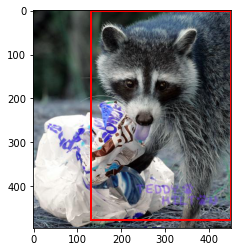

In [47]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# VGG16 Implementation

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [60]:
Image_size = 224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [61]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * Image_size / width
        coords[i,1] = ymin * Image_size / height
        coords[i,2] = xmax * Image_size / width # Normalize bounding box by image size
        coords[i,3] = ymax * Image_size / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [63]:
from PIL import Image
batch_images = np.zeros((len(paths), Image_size, Image_size, 3), dtype=np.float32)

for i, f in enumerate(paths):
    img = Image.open('images/'+ f) # Read image
    img = img.resize((Image_size, Image_size)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D(optional to learner)

In [64]:
model_vgg = VGG16(weights = 'imagenet', include_top= False, input_shape=(Image_size,Image_size,3))

for layer in model_vgg.layers:
    layer.trainable=False

In [65]:
x2 = model_vgg.output
print(x2.shape)
x2 = GlobalAveragePooling2D()(x2)
print(x2.shape)
x2 = RepeatVector(8)(x2)
print(x2.shape)
x2= Conv1D(4,kernel_size=8,name='coords')(x2)
print(x2.shape)
x2 = Flatten()(x2)
print(x2.shape)

model_vgg  = Model(inputs=model_vgg.input, outputs=x2)

(None, 7, 7, 512)
(None, 512)
(None, 8, 512)
(None, 1, 4)
(None, 4)


### Plot the Vgg16 model using plot_model function.

In [66]:
!pip install pydot

You should consider upgrading via the '/Users/rajan.sethi/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [67]:
tf.keras.utils.plot_model(model_vgg)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [68]:
gt = coords
print(len(coords))
model_vgg.compile(optimizer='Adam', loss='mse',metrics=[IoU])
# model_vgg.fit(batch_images, gt, epochs=30, batch_size=32, verbose=1)

173


In [69]:

model_vgg.fit(batch_images, gt, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
6/6 [==============================] - 42s 7s/step - loss: 19354.4107 - IoU: 0.0369
Epoch 2/30
6/6 [==============================] - 40s 6s/step - loss: 18149.6507 - IoU: 0.0384
Epoch 3/30
6/6 [==============================] - 52s 9s/step - loss: 17121.2059 - IoU: 0.0329
Epoch 4/30
6/6 [==============================] - 45s 7s/step - loss: 16567.2363 - IoU: 0.0292
Epoch 5/30
6/6 [==============================] - 44s 7s/step - loss: 15403.9812 - IoU: 0.0193
Epoch 6/30
6/6 [==============================] - 43s 7s/step - loss: 14641.2464 - IoU: 0.0190
Epoch 7/30
6/6 [==============================] - 40s 6s/step - loss: 13849.5177 - IoU: 0.0206
Epoch 8/30
6/6 [==============================] - 40s 6s/step - loss: 13161.2068 - IoU: 0.0214
Epoch 9/30
6/6 [==============================] - 40s 7s/step - loss: 12567.4198 - IoU: 0.0279
Epoch 10/30
6/6 [==============================] - 41s 7s/step - loss: 11965.4841 - IoU: 0.0369
Epoch 11/30
6/6 [==============================] 

### Pick a test image from the given data

In [70]:

filename = 'images/raccoon-10.jpg'
unscaled = cv2.imread(filename) 

### Resize the image to 224 * 224 and preprocess the image for the VGG16

In [71]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (Image_size, Image_size)) 
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [72]:
region = model_vgg.predict(x=np.array([feat_scaled]))[0] 

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

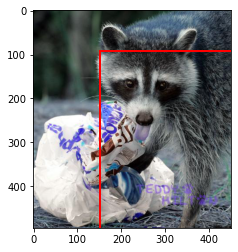

In [73]:
x0 = int(region[0] * image_width / IMAGE_SIZE) 
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Visualizing model details in tensorboard

In [74]:
%load_ext tensorboard

In [75]:
import os
import datetime

!rm -rf ./logs/
logs_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_dir, histogram_freq = 1)
print(logs_dir)

logs/fit/20210526-192825


In [76]:
model_vgg.fit(batch_images, gt, epochs=30, batch_size=32, verbose=1,callbacks=[tensorboard_callback])

Epoch 1/30
6/6 [==============================] - 104s 16s/step - loss: 3801.2771 - IoU: 0.2684
Epoch 2/30
6/6 [==============================] - 98s 16s/step - loss: 3599.2966 - IoU: 0.2817
Epoch 3/30
6/6 [==============================] - 103s 17s/step - loss: 3408.8274 - IoU: 0.2950
Epoch 4/30
6/6 [==============================] - 100s 16s/step - loss: 3230.5051 - IoU: 0.3103
Epoch 5/30
6/6 [==============================] - 101s 16s/step - loss: 3061.3789 - IoU: 0.3121
Epoch 6/30
6/6 [==============================] - 101s 16s/step - loss: 2905.4729 - IoU: 0.3215
Epoch 7/30
6/6 [==============================] - 98s 16s/step - loss: 2756.9023 - IoU: 0.3418
Epoch 8/30
6/6 [==============================] - 100s 16s/step - loss: 2617.8418 - IoU: 0.3478
Epoch 9/30
6/6 [==============================] - 98s 16s/step - loss: 2490.3782 - IoU: 0.3553
Epoch 10/30
6/6 [==============================] - 98s 16s/step - loss: 2369.4893 - IoU: 0.3668
Epoch 11/30
6/6 [==========================

In [ ]:
%tensorboard --logs_dir logs/fit/